In [2]:
# maximale fläche in der daten 8die Slice mit der größten GT-Fläche als Seed)

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2 Imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierung
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Gerät
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

def process_images_with_seed_maxarea(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()   # (H,W,Z)
            mask_data  = nifti_mask.get_fdata()    # (H,W,Z)

            H, W, Z = image_data.shape

            # ---- Seed auswählen: Slice mit größter GT-Fläche ----
            slice_areas = [np.sum(mask_data[:, :, s] > 0) for s in range(Z)]
            seed_idx = int(np.argmax(slice_areas))
            if slice_areas[seed_idx] == 0:
                logging.warning(f"{mask_file}: keine GT in irgendeiner Slice – übersprungen.")
                progress.update(1)
                continue
            logging.info(f"{mask_file}: Seed-Slice (größte Fläche) = {seed_idx} (Area={slice_areas[seed_idx]:.0f})")

            # ---- Bounding Box aus Seed-Slice (ohne Padding) ----
            seed_mask = (mask_data[:, :, seed_idx] > 0).astype(np.uint8)
            ys, xs = np.where(seed_mask > 0)
            y_min, y_max = ys.min(), ys.max()
            x_min, x_max = xs.min(), xs.max()
            box_np = np.array([[x_min, y_min, x_max, y_max]], dtype=np.float32)  # [x1,y1,x2,y2]

            # ---- Box → 1024 Koordinaten ----
            box_1024 = box_np / np.array([W, H, W, H], dtype=np.float32) * 1024.0  # (1,4)

            # ---- Volumen normalisieren (Z,1024,1024,3) ----
            image_volume = []
            for z in range(Z):
                img_resized = transform.resize(image_data[:, :, z], (1024, 1024),
                                               order=3, preserve_range=True, anti_aliasing=True)
                img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # ---- Segmentierung: dieselbe Seed-Box auf alle Slices ----
            mask_3d = []
            for z in range(Z):
                predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                mask_slice = predictor.predict(box=box_1024, multimask_output=False)[0]
                mask_slice = np.squeeze(mask_slice).astype(np.uint8)  # (1024,1024)
                mask_3d.append(mask_slice)
            mask_3d = np.array(mask_3d, dtype=np.uint8)  # (Z,1024,1024)

            # ---- Speichern ----
            case_out_dir = os.path.join(output_dir, mask_file.replace(".nii.gz", "").replace(".nii",""))
            os.makedirs(case_out_dir, exist_ok=True)

            if save_png:
                for z in range(Z):
                    seg_file = os.path.join(case_out_dir, f"slice_{z}_segmentation.png")
                    plt.imsave(seg_file, mask_3d[z], cmap="gray")

                # Visualisierung auf Seed-Slice
                vis_file = os.path.join(case_out_dir, f"seed_slice_{seed_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[seed_idx][:, :, 0], cmap="gray")
                show_box(box_1024[0], ax[0])
                ax[0].set_title(f"Seed-Slice {seed_idx} mit Bounding Box")
                ax[1].imshow(image_volume[seed_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[seed_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                plt.savefig(vis_file, dpi=150, bbox_inches="tight")
                plt.close(fig)

            # NIfTI speichern (Z,1024,1024) → als (1024,1024,Z) ablegen
            nifti_out = nib.Nifti1Image(np.transpose(mask_3d, (1,2,0)).astype(np.uint8), affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            del mask_3d, image_volume
            gc.collect()
            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# --- Aufruf ---
images_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_images"
masks_dir  = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_seed_maxarea"
os.makedirs(output_dir, exist_ok=True)

process_images_with_seed_maxarea(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="spleen_10.nii.gz",
    save_png=True
)


2025-08-17 14:15:06,093 - INFO - Verwende Gerät: cpu
2025-08-17 14:15:06,093 - INFO - Using device: cpu
2025-08-17 14:15:12,093 - INFO - Loaded checkpoint sucessfully
2025-08-17 14:15:13,171 - INFO - MedSAM2 model loaded successfully.
Dateien:   0%|                                                                               | 0/41 [00:00<?, ?Datei/s]2025-08-17 14:15:13,859 - INFO - spleen_10.nii.gz: Seed-Slice (größte Fläche) = 7 (Area=5043)
2025-08-17 14:15:22,734 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-17 14:15:23,550 - INFO - Computing image embeddings for the provided image...
2025-08-17 14:15:25,888 - INFO - Image embeddings computed.
2025-08-17 14:15:26,561 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-17 14:15:26,644 - INFO - Computing image embeddings for the provided image...
2025-08-17 14:15:27,463 - INFO - Image embeddings computed.
2025-08-17 14:15:27,539 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-17 14:15:

In [4]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit GT (Ground Truth)
gt_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks_updated"
# Ordner mit Predictions (MedSAM2 zentrale Slice)
pred_root = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_seed_maxarea"

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

def process_single_file(gt_filename):
    # Beispiel GT: spleen_2_slice_01_segmentation.png
    parts = gt_filename.split("_slice_")
    case_name = parts[0]  # spleen_2
    slice_part = parts[1]  # 01_segmentation.png
    slice_num_str = slice_part.split("_")[0]  # "01"
    slice_num_gt = int(slice_num_str)  # GT ist 1-basiert
    slice_num_pred = slice_num_gt - 1  # Prediction ist 0-basiert

    # Prediction-Pfad bauen
    pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num_pred}_segmentation.png")
    gt_path = os.path.join(gt_dir, gt_filename)

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction nicht gefunden: {pred_path}")
        return None

    # Masken laden
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None or pred_mask is None:
        logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
        return None

    # Binär machen
    gt_mask = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    # Falls Größen unterschiedlich → Prediction auf GT-Größe anpassen
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Dice Score berechnen
    dice = dice_score(gt_mask, pred_mask)
    logging.info(f"{gt_filename}: Dice Score = {dice:.4f}")
    return gt_filename, dice

# Parallelisierte Verarbeitung
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, f)
               for f in os.listdir(gt_dir) if f.endswith(".png")]
    dice_scores = [res for res in (f.result() for f in futures) if res is not None]

# Ergebnisse speichern und Durchschnitt berechnen
if dice_scores:
    out_csv = "dice_scores_medsam2_seed_maxarea.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["GT Filename", "Dice Score"])
        writer.writerows(dice_scores)
    mean_dice = np.mean([score for _, score in dice_scores])
    logging.info(f"Durchschnittlicher Dice Score: {mean_dice:.4f}")
else:
    logging.info("Keine Dice Scores berechnet!")


2025-08-18 16:28:56,742 - INFO - spleen_3_slice_02_segmentation.png: Dice Score = 0.4399
2025-08-18 16:28:56,764 - INFO - spleen_3_slice_08_segmentation.png: Dice Score = 0.9583
2025-08-18 16:28:56,758 - INFO - spleen_3_slice_03_segmentation.png: Dice Score = 0.9057
2025-08-18 16:28:56,758 - INFO - spleen_3_slice_07_segmentation.png: Dice Score = 0.9350
2025-08-18 16:28:56,830 - INFO - spleen_3_slice_10_segmentation.png: Dice Score = 0.9488
2025-08-18 16:28:56,848 - INFO - spleen_3_slice_12_segmentation.png: Dice Score = 0.8517
2025-08-18 16:28:56,896 - INFO - spleen_3_slice_05_segmentation.png: Dice Score = 0.9459
2025-08-18 16:28:56,938 - INFO - spleen_3_slice_13_segmentation.png: Dice Score = 0.0179
2025-08-18 16:28:56,959 - INFO - spleen_3_slice_01_segmentation.png: Dice Score = 0.0000
2025-08-18 16:28:56,945 - INFO - spleen_3_slice_04_segmentation.png: Dice Score = 0.8137
2025-08-18 16:28:56,959 - INFO - spleen_3_slice_09_segmentation.png: Dice Score = 0.9563
2025-08-18 16:28:56,9

2025-08-18 16:29:18,362 - INFO - 
Durchschnittlicher Dice Score: 0.6747


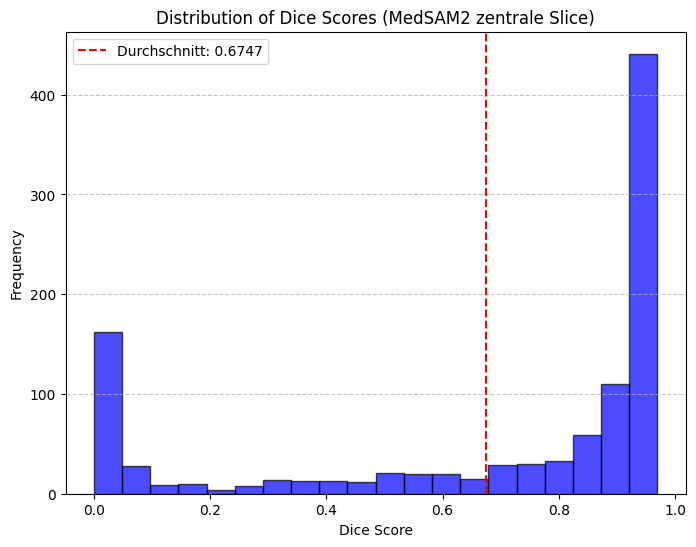

In [5]:

# Ergebnisse + Visualisierung
if dice_scores:
    # CSV speichern
    out_csv = "dice_scores_medsam2_seed_maxarea.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (MedSAM2 zentrale Slice)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnittslinie
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    plt.savefig('dice_score_histogram_Medsam2_Spleen_seed_maxarea.png')
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")

In [2]:
# -*- coding: utf-8 -*-
import os
import json
import time
import csv
import gc
import logging
from typing import Optional

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
from tqdm import tqdm

# ================== MedSAM2 Imports ==================
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ================== Logging ==================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ================== Visualisierung ==================
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# ================== Gerät ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# ================== Modell laden ==================
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    # ckpt_path="checkpoints/MedSAM2_2411.pt",
    ckpt_path=r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# ================== Helper: Zeitformat & CSV-Summe ==================
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

# ================== Runtime-State (Wall-Clock) ==================
def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Konnte Runtime-State nicht lesen: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Führt func aus, misst Wall-Clock-Zeit des aktuellen Runs und akkumuliert in state_path.
    Zusätzlich wird am Ende die *echte* Gesamtlaufzeit (Summe der Slice-Zeiten) aus seed_timing_csv geloggt.
    """
    state = _load_runtime_state(state_path)
    start_perf = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start_perf
        end_wall = time.time()

        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)

        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)

        # Logfile neben der Ausgabe halten (falls vorhanden)
        log_dir = os.path.dirname(seed_timing_csv) if seed_timing_csv else "."
        with open(os.path.join(log_dir, "runtime_log_medsam2_seed.txt"), "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# ================== Pipeline ==================
@torch.no_grad()
def process_images_with_seed_maxarea(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    save_png: bool = True
):
    """
    - Wählt pro Fall die Seed-Slice mit größter GT-Fläche
    - Nutzt deren Bounding-Box (in 1024-Koordinaten) als Prompt für alle Slices
    - Schreibt pro Slice die Rechenzeit in timing_csv (persistiert über Neustarts)
    - Resume auf Dateiebene (optional über resume_file)
    """
    os.makedirs(output_dir, exist_ok=True)

    # timing CSV initialisieren
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    resume = resume_file is None
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            # --------- NIfTI laden ---------
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            image_data = nifti_image.get_fdata(dtype=np.float32)  # (H,W,Z)
            mask_data  = nifti_mask.get_fdata(dtype=np.float32)   # (H,W,Z)

            H, W, Z = image_data.shape

            # --------- Seed auswählen: größte GT-Fläche ---------
            slice_areas = [float(np.sum(mask_data[:, :, s] > 0)) for s in range(Z)]
            seed_idx = int(np.argmax(slice_areas))
            if slice_areas[seed_idx] == 0:
                logging.warning(f"{mask_file}: keine GT in irgendeiner Slice – übersprungen.")
                progress.update(1)
                continue
            logging.info(f"{mask_file}: Seed-Slice (größte Fläche) = {seed_idx} (Area={slice_areas[seed_idx]:.0f})")

            # --------- Bounding Box aus Seed-Slice ---------
            seed_mask = (mask_data[:, :, seed_idx] > 0)
            ys, xs = np.where(seed_mask)
            y_min, y_max = int(ys.min()), int(ys.max())
            x_min, x_max = int(xs.min()), int(xs.max())
            box_np = np.array([[x_min, y_min, x_max, y_max]], dtype=np.float32)  # [x1,y1,x2,y2]
            box_1024 = box_np / np.array([W, H, W, H], dtype=np.float32) * 1024.0  # (1,4)

            # --------- Volumen vorbereiten (Z,1024,1024,3) ---------
            image_volume = []
            for z in range(Z):
                img_resized = transform.resize(
                    image_data[:, :, z],
                    (1024, 1024),
                    order=3, preserve_range=True, anti_aliasing=True
                )
                ptp = float(img_resized.max() - img_resized.min())
                img_norm = (img_resized - img_resized.min()) / (ptp + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.asarray(image_volume, dtype=np.float32)

            # --------- Segmentierung (dieselbe Box auf alle Slices) ---------
            mask_3d = []
            with tqdm(total=Z, desc=f"Slices in {mask_file}", unit="Slice") as prog_slices:
                for z in range(Z):
                    t0 = time.perf_counter()
                    try:
                        predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                        masks, scores, logits = predictor.predict(
                            box=box_1024.squeeze().tolist(),
                            multimask_output=False
                        )
                        mask_slice = np.squeeze(masks[0]).astype(np.uint8)  # (1024,1024)
                        mask_3d.append(mask_slice)
                    except Exception as e:
                        logging.error(f"Fehler bei {mask_file} Slice {z}: {e}")
                        # leere Maske einfügen, damit Dimensionen konsistent bleiben
                        mask_3d.append(np.zeros((1024, 1024), dtype=np.uint8))
                    finally:
                        elapsed_slice = time.perf_counter() - t0
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([mask_file, z, f"{elapsed_slice:.4f}"])
                        prog_slices.update(1)

            mask_3d = np.asarray(mask_3d, dtype=np.uint8)  # (Z,1024,1024)

            # --------- Speichern ---------
            case_out_dir = os.path.join(
                output_dir,
                mask_file.replace(".nii.gz", "").replace(".nii", "")
            )
            os.makedirs(case_out_dir, exist_ok=True)

            if save_png:
                for z in range(Z):
                    seg_file = os.path.join(case_out_dir, f"slice_{z}_segmentation.png")
                    plt.imsave(seg_file, mask_3d[z], cmap="gray")

                # Visualisierung auf Seed-Slice
                vis_file = os.path.join(case_out_dir, f"seed_slice_{seed_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[seed_idx][:, :, 0], cmap="gray")
                show_box(box_1024[0], ax[0])
                ax[0].set_title(f"Seed-Slice {seed_idx} mit Bounding Box")
                ax[1].imshow(image_volume[seed_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[seed_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                for a in ax:
                    a.axis('off')
                plt.savefig(vis_file, dpi=150, bbox_inches="tight")
                plt.close(fig)

            # NIfTI speichern (Z,1024,1024) → (1024,1024,Z)
            nifti_out = nib.Nifti1Image(
                np.transpose(mask_3d, (1, 2, 0)).astype(np.uint8),
                affine=nifti_image.affine
            )
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            # Cleanup
            del mask_3d, image_volume
            gc.collect()
            if device.type == "cuda":
                torch.cuda.empty_cache()
            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# ================== AUSFÜHRUNG ==================
if __name__ == "__main__":
    images_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_images"
    masks_dir  = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks"
    output_dir = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_seed_maxarea_with_run_time"
    os.makedirs(output_dir, exist_ok=True)

    timing_csv    = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state = os.path.join(output_dir, "runtime_state_seed.json")

    # Optional: ab welcher Datei fortsetzen (Resume auf Dateiebene)
    manual_resume_file = None  # oder None

    # Lauf starten (Wall-Clock akkumuliert + CSV-basierte Gesamtzeit)
    time_run_accumulate(
        process_images_with_seed_maxarea,
        runtime_state,               # state_path
        seed_timing_csv=timing_csv,  # für die CSV-Summe am Ende
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        timing_csv=timing_csv,       # Pflichtargument für Pipeline (per-Slice-Zeiten)
        resume_file=manual_resume_file,
        save_png=True
    )

    # Optional: CSV-Gesamtzeit explizit loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit aus CSV (alle Neustarts): {_fmt(total_csv_sec)}")


2025-09-14 13:38:06,556 - INFO - Verwende Gerät: cpu
2025-09-14 13:38:06,557 - INFO - Using device: cpu
2025-09-14 13:38:11,975 - INFO - Loaded checkpoint sucessfully
2025-09-14 13:38:13,180 - INFO - MedSAM2 model loaded successfully.
2025-09-14 13:38:13,263 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
Dateien:   0%|                                                                               | 0/41 [00:00<?, ?Datei/s]2025-09-14 13:38:13,971 - INFO - spleen_10.nii.gz: Seed-Slice (größte Fläche) = 7 (Area=5043)

Slices in spleen_10.nii.gz:   0%|                                                            | 0/17 [00:00<?, ?Slice/s]2025-09-14 13:38:23,522 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-14 13:38:24,321 - INFO - Computing image embeddings for the provided image...
2025-09-14 13:38:26,430 - INFO - Image embeddings computed.

Slices in spleen_10.nii.gz:   6%|███                                                 | 1/17 [00:03<00:58,  3.66s/Slice]2025-

In [5]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2 Imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierung
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Gerät
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# Hauptfunktion
def process_images_with_propagation(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)

            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()

            # Zentralen Slice bestimmen (größte Maske)
            slice_areas = [np.sum(mask_data[:, :, s]) for s in range(mask_data.shape[2])]
            central_slice_idx = int(np.argmax(slice_areas))
            logging.info(f"Zentraler Slice für {mask_file}: {central_slice_idx}")

            # Bounding Box nur für zentralen Slice
            mask_central = mask_data[:, :, central_slice_idx]
            non_zero_coords = np.argwhere(mask_central > 0)
            y_min, x_min = non_zero_coords.min(axis=0)
            y_max, x_max = non_zero_coords.max(axis=0)
            box_np = np.array([[x_min, y_min, x_max, y_max]])

            H, W = image_data.shape[:2]
            box_1024 = box_np / np.array([W, H, W, H]) * 1024

            # Volumen normalisieren (Slices, 1024, 1024, 3) float32
            image_volume = []
            for slice_idx in range(image_data.shape[2]):
                img_slice = image_data[:, :, slice_idx]
                img_resized = transform.resize(img_slice, (1024, 1024), order=3,
                                               preserve_range=True, anti_aliasing=True)
                img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # 3D Segmentierung: gleiche Box für alle Slices
            mask_3d = []
            for slice_idx in range(image_volume.shape[0]):
                predictor.set_image((image_volume[slice_idx] * 255).astype(np.uint8))
                mask_slice = predictor.predict(box=box_1024, multimask_output=False)[0]
                mask_slice = np.squeeze(mask_slice).astype(np.uint8)  # <-- sicherstellen HxW
                mask_3d.append(mask_slice)
            mask_3d = np.array(mask_3d)

            # Ergebnisse speichern
            case_out_dir = os.path.join(output_dir, mask_file.replace(".nii.gz", ""))
            os.makedirs(case_out_dir, exist_ok=True)

            # PNG-Slices optional speichern
            if save_png:
                for slice_idx in range(mask_3d.shape[0]):
                    seg_file = os.path.join(case_out_dir, f"slice_{slice_idx}_segmentation.png")
                    plt.imsave(seg_file, mask_3d[slice_idx], cmap="gray")

                # Visualisierung des zentralen Slice
                vis_file = os.path.join(case_out_dir, f"central_slice_{central_slice_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                show_box(box_1024[0], ax[0])
                ax[0].set_title(f"Zentraler Slice {central_slice_idx} mit Bounding Box")
                ax[1].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[central_slice_idx], ax[1])
                ax[1].set_title(f"Segmentierung Zentraler Slice")
                plt.savefig(vis_file)
                plt.close(fig)

            # Maske als NIfTI speichern
            nifti_out = nib.Nifti1Image(mask_3d.astype(np.uint8), affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            del mask_3d, image_volume
            gc.collect()

            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# Ordner definieren
images_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_images"
masks_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_zentrale_slice"
os.makedirs(output_dir, exist_ok=True)

# Starten
process_images_with_propagation(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="spleen_10.nii.gz",
    save_png=True   # <- False setzen, wenn du nur NIfTI willst
)


2025-08-06 17:43:07,219 - INFO - Verwende Gerät: cpu
2025-08-06 17:43:07,221 - INFO - Using device: cpu
2025-08-06 17:43:11,001 - INFO - Loaded checkpoint sucessfully
2025-08-06 17:43:11,464 - INFO - MedSAM2 model loaded successfully.
Dateien:   0%|                                                                               | 0/41 [00:00<?, ?Datei/s]2025-08-06 17:43:12,026 - INFO - Zentraler Slice für spleen_10.nii.gz: 7
2025-08-06 17:43:14,914 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-06 17:43:15,320 - INFO - Computing image embeddings for the provided image...
2025-08-06 17:43:17,791 - INFO - Image embeddings computed.
2025-08-06 17:43:17,951 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-06 17:43:17,995 - INFO - Computing image embeddings for the provided image...
2025-08-06 17:43:20,106 - INFO - Image embeddings computed.
2025-08-06 17:43:20,207 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-06 17:43:20,251 - INFO - Compu

In [4]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit GT (Ground Truth)
gt_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks_updated"
# Ordner mit Predictions (MedSAM2 zentrale Slice)
pred_root = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_zentrale_slice"

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

def process_single_file(gt_filename):
    # Beispiel GT: spleen_2_slice_01_segmentation.png
    parts = gt_filename.split("_slice_")
    case_name = parts[0]  # spleen_2
    slice_part = parts[1]  # 01_segmentation.png
    slice_num_str = slice_part.split("_")[0]  # "01"
    slice_num_gt = int(slice_num_str)  # GT ist 1-basiert
    slice_num_pred = slice_num_gt - 1  # Prediction ist 0-basiert

    # Prediction-Pfad bauen
    pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num_pred}_segmentation.png")
    gt_path = os.path.join(gt_dir, gt_filename)

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction nicht gefunden: {pred_path}")
        return None

    # Masken laden
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None or pred_mask is None:
        logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
        return None

    # Binär machen
    gt_mask = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    # Falls Größen unterschiedlich → Prediction auf GT-Größe anpassen
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Dice Score berechnen
    dice = dice_score(gt_mask, pred_mask)
    logging.info(f"{gt_filename}: Dice Score = {dice:.4f}")
    return gt_filename, dice

# Parallelisierte Verarbeitung
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, f)
               for f in os.listdir(gt_dir) if f.endswith(".png")]
    dice_scores = [res for res in (f.result() for f in futures) if res is not None]

# Ergebnisse speichern und Durchschnitt berechnen
if dice_scores:
    out_csv = "dice_scores_medsam2_central_slice.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["GT Filename", "Dice Score"])
        writer.writerows(dice_scores)
    mean_dice = np.mean([score for _, score in dice_scores])
    logging.info(f"Durchschnittlicher Dice Score: {mean_dice:.4f}")
else:
    logging.info("Keine Dice Scores berechnet!")


2025-08-15 16:27:02,126 - INFO - spleen_3_slice_02_segmentation.png: Dice Score = 0.4399
2025-08-15 16:27:02,159 - INFO - spleen_3_slice_04_segmentation.png: Dice Score = 0.8137
2025-08-15 16:27:02,171 - INFO - spleen_3_slice_01_segmentation.png: Dice Score = 0.0000
2025-08-15 16:27:02,216 - INFO - spleen_3_slice_06_segmentation.png: Dice Score = 0.9312
2025-08-15 16:27:02,217 - INFO - spleen_3_slice_05_segmentation.png: Dice Score = 0.9459
2025-08-15 16:27:02,224 - INFO - spleen_3_slice_08_segmentation.png: Dice Score = 0.9583
2025-08-15 16:27:02,225 - INFO - spleen_3_slice_03_segmentation.png: Dice Score = 0.9057
2025-08-15 16:27:02,228 - INFO - spleen_3_slice_07_segmentation.png: Dice Score = 0.9350
2025-08-15 16:27:02,291 - INFO - spleen_3_slice_12_segmentation.png: Dice Score = 0.8517
2025-08-15 16:27:02,318 - INFO - spleen_3_slice_11_segmentation.png: Dice Score = 0.8755
2025-08-15 16:27:02,351 - INFO - spleen_3_slice_13_segmentation.png: Dice Score = 0.0179
2025-08-15 16:27:02,3

2025-08-15 16:28:35,444 - INFO - 
Durchschnittlicher Dice Score: 0.6747


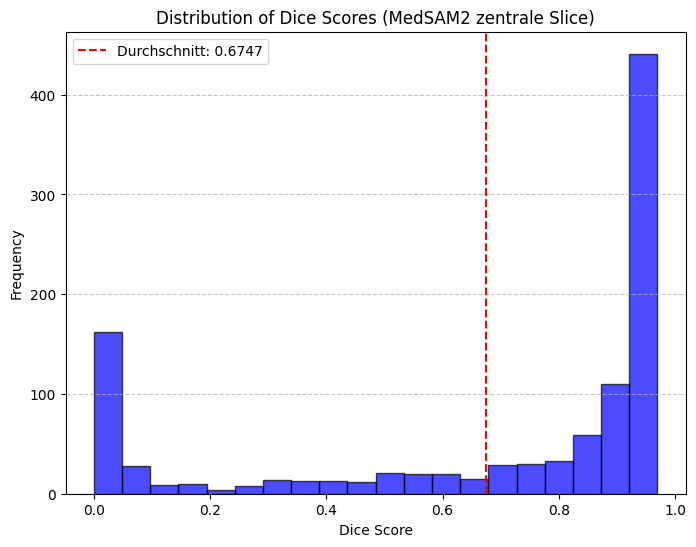

In [5]:

# Ergebnisse + Visualisierung
if dice_scores:
    # CSV speichern
    out_csv = "dice_scores_medsam2_central_slice.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (MedSAM2 zentrale Slice)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnittslinie
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    plt.savefig('dice_score_histogram_medsam2_central_slice.png')
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")

In [9]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2 Imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierung
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Gerät
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

def process_images_with_propagation_5seeds(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()

            total_slices = mask_data.shape[2]

            # Zentralen Slice bestimmen (größte Maske)
            slice_areas = [np.sum(mask_data[:, :, s]) for s in range(total_slices)]
            central_slice_idx = int(np.argmax(slice_areas))

            # 5 Seeds auswählen (±2 Slices vom Zentrum)
            seed_slices = sorted(set([
                central_slice_idx - 2,
                central_slice_idx - 1,
                central_slice_idx,
                central_slice_idx + 1,
                central_slice_idx + 2
            ]))
            seed_slices = [s for s in seed_slices if 0 <= s < total_slices]
            logging.info(f"{mask_file}: Seeds bei Slices {seed_slices}")

            # Für jede Seed-Slice eine Box berechnen
            seed_boxes = {}
            H, W = image_data.shape[:2]
            for s in seed_slices:
                mask_seed = mask_data[:, :, s]
                non_zero_coords = np.argwhere(mask_seed > 0)
                if non_zero_coords.size == 0:
                    continue
                y_min, x_min = non_zero_coords.min(axis=0)
                y_max, x_max = non_zero_coords.max(axis=0)
                box_np = np.array([[x_min, y_min, x_max, y_max]])
                box_1024 = box_np / np.array([W, H, W, H]) * 1024
                seed_boxes[s] = box_1024

            # Volumen normalisieren (Slices, 1024, 1024, 3)
            image_volume = []
            for slice_idx in range(total_slices):
                img_slice = image_data[:, :, slice_idx]
                img_resized = transform.resize(img_slice, (1024, 1024), order=3,
                                               preserve_range=True, anti_aliasing=True)
                img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # Für jede Slice die Box des nächstliegenden Seeds verwenden
            mask_3d = []
            for slice_idx in range(total_slices):
                if not seed_boxes:
                    mask_3d.append(np.zeros((1024, 1024), dtype=np.uint8))
                    continue
                nearest_seed = min(seed_boxes.keys(), key=lambda s: abs(s - slice_idx))
                box_1024 = seed_boxes[nearest_seed]

                predictor.set_image((image_volume[slice_idx] * 255).astype(np.uint8))
                mask_slice = predictor.predict(box=box_1024, multimask_output=False)[0]
                mask_slice = np.squeeze(mask_slice).astype(np.uint8)
                mask_3d.append(mask_slice)
            mask_3d = np.array(mask_3d)

            # Ergebnisse speichern
            case_out_dir = os.path.join(output_dir, mask_file.replace(".nii.gz", ""))
            os.makedirs(case_out_dir, exist_ok=True)

            if save_png:
                for slice_idx in range(mask_3d.shape[0]):
                    seg_file = os.path.join(case_out_dir, f"slice_{slice_idx}_segmentation.png")
                    plt.imsave(seg_file, mask_3d[slice_idx], cmap="gray")

                # Visualisierung eines Seeds (zentral)
                vis_file = os.path.join(case_out_dir, f"central_slice_{central_slice_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                if central_slice_idx in seed_boxes:
                    show_box(seed_boxes[central_slice_idx][0], ax[0])
                ax[0].set_title(f"Zentraler Slice {central_slice_idx} mit Bounding Box")
                ax[1].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[central_slice_idx], ax[1])
                ax[1].set_title(f"Segmentierung Zentraler Slice")
                plt.savefig(vis_file)
                plt.close(fig)

            # NIfTI speichern
            nifti_out = nib.Nifti1Image(mask_3d.astype(np.uint8), affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            del mask_3d, image_volume
            gc.collect()
            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# --- Aufruf ---
images_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_images"
masks_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_5seeds"
os.makedirs(output_dir, exist_ok=True)

process_images_with_propagation_5seeds(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="spleen_10.nii.gz",
    save_png=True
)


2025-08-15 17:01:12,339 - INFO - Verwende Gerät: cpu
2025-08-15 17:01:12,344 - INFO - Using device: cpu
2025-08-15 17:01:17,722 - INFO - Loaded checkpoint sucessfully
2025-08-15 17:01:18,024 - INFO - MedSAM2 model loaded successfully.
Dateien:   0%|                                                                               | 0/41 [00:00<?, ?Datei/s]2025-08-15 17:01:18,418 - INFO - spleen_10.nii.gz: Seeds bei Slices [5, 6, 7, 8, 9]
2025-08-15 17:01:20,759 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-15 17:01:20,826 - INFO - Computing image embeddings for the provided image...
2025-08-15 17:01:22,058 - INFO - Image embeddings computed.
2025-08-15 17:01:22,144 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-15 17:01:22,169 - INFO - Computing image embeddings for the provided image...
2025-08-15 17:01:23,198 - INFO - Image embeddings computed.
2025-08-15 17:01:23,278 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-15 17:01:23,300 - I

In [10]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit GT (Ground Truth)
gt_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks_updated"
# Ordner mit Predictions (MedSAM2 zentrale Slice)
pred_root = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_5seeds"

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

def process_single_file(gt_filename):
    # Beispiel GT: spleen_2_slice_01_segmentation.png
    parts = gt_filename.split("_slice_")
    case_name = parts[0]  # spleen_2
    slice_part = parts[1]  # 01_segmentation.png
    slice_num_str = slice_part.split("_")[0]  # "01"
    slice_num_gt = int(slice_num_str)  # GT ist 1-basiert
    slice_num_pred = slice_num_gt - 1  # Prediction ist 0-basiert

    # Prediction-Pfad bauen
    pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num_pred}_segmentation.png")
    gt_path = os.path.join(gt_dir, gt_filename)

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction nicht gefunden: {pred_path}")
        return None

    # Masken laden
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None or pred_mask is None:
        logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
        return None

    # Binär machen
    gt_mask = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    # Falls Größen unterschiedlich → Prediction auf GT-Größe anpassen
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Dice Score berechnen
    dice = dice_score(gt_mask, pred_mask)
    logging.info(f"{gt_filename}: Dice Score = {dice:.4f}")
    return gt_filename, dice

# Parallelisierte Verarbeitung
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, f)
               for f in os.listdir(gt_dir) if f.endswith(".png")]
    dice_scores = [res for res in (f.result() for f in futures) if res is not None]

# Ergebnisse speichern und Durchschnitt berechnen
if dice_scores:
    out_csv = "dice_scores_medsam2_central_slice.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["GT Filename", "Dice Score"])
        writer.writerows(dice_scores)
    mean_dice = np.mean([score for _, score in dice_scores])
    logging.info(f"Durchschnittlicher Dice Score: {mean_dice:.4f}")
else:
    logging.info("Keine Dice Scores berechnet!")


2025-08-15 17:31:28,814 - INFO - spleen_3_slice_06_segmentation.png: Dice Score = 0.9379
2025-08-15 17:31:28,839 - INFO - spleen_3_slice_01_segmentation.png: Dice Score = 0.0000
2025-08-15 17:31:28,849 - INFO - spleen_3_slice_07_segmentation.png: Dice Score = 0.9478
2025-08-15 17:31:28,839 - INFO - spleen_3_slice_03_segmentation.png: Dice Score = 0.9231
2025-08-15 17:31:28,852 - INFO - spleen_3_slice_08_segmentation.png: Dice Score = 0.9600
2025-08-15 17:31:28,877 - INFO - spleen_3_slice_04_segmentation.png: Dice Score = 0.9167
2025-08-15 17:31:28,858 - INFO - spleen_3_slice_02_segmentation.png: Dice Score = 0.4734
2025-08-15 17:31:28,852 - INFO - spleen_3_slice_05_segmentation.png: Dice Score = 0.9459
2025-08-15 17:31:28,991 - INFO - spleen_8_slice_02_segmentation.png: Dice Score = 0.8796
2025-08-15 17:31:28,998 - INFO - spleen_3_slice_12_segmentation.png: Dice Score = 0.9647
2025-08-15 17:31:29,020 - INFO - spleen_3_slice_13_segmentation.png: Dice Score = 0.8993
2025-08-15 17:31:29,0

2025-08-15 17:31:58,243 - INFO - 
Durchschnittlicher Dice Score: 0.7081


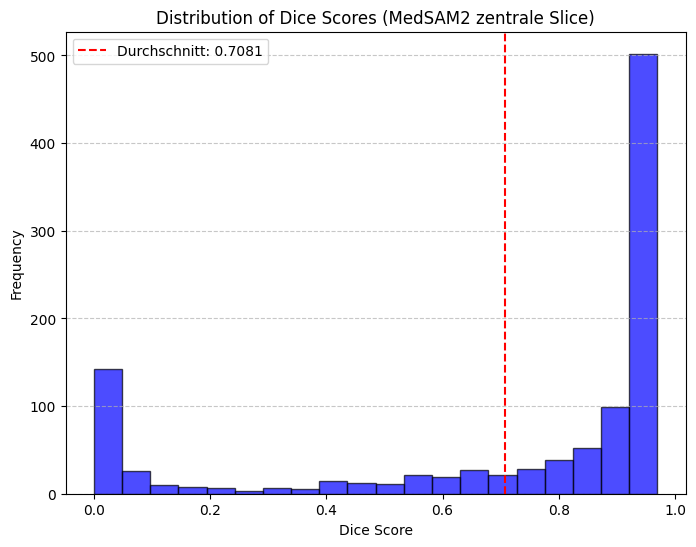

In [11]:

# Ergebnisse + Visualisierung
if dice_scores:
    # CSV speichern
    out_csv = "dice_scores_medsam2_central_slice.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (MedSAM2 zentrale Slice)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnittslinie
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    plt.savefig('dice_score_histogram_medsam2_central_slice.png')
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2 Imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierung
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Gerät
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

def process_images_with_propagation_3seeds(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()

            total_slices = mask_data.shape[2]

            # Seed-Slices auswählen: erste, mittlere, letzte
            seed_slices = [0, total_slices // 2, total_slices - 1]
            logging.info(f"{mask_file}: Seeds bei Slices {seed_slices}")

            # Boxen für Seeds berechnen
            seed_boxes = {}
            H, W = image_data.shape[:2]
            for s in seed_slices:
                mask_seed = mask_data[:, :, s]
                non_zero_coords = np.argwhere(mask_seed > 0)
                if non_zero_coords.size == 0:
                    continue
                y_min, x_min = non_zero_coords.min(axis=0)
                y_max, x_max = non_zero_coords.max(axis=0)
                box_np = np.array([[x_min, y_min, x_max, y_max]])
                box_1024 = box_np / np.array([W, H, W, H]) * 1024
                seed_boxes[s] = box_1024

            # Volumen normalisieren (Slices, 1024, 1024, 3)
            image_volume = []
            for slice_idx in range(total_slices):
                img_slice = image_data[:, :, slice_idx]
                img_resized = transform.resize(img_slice, (1024, 1024), order=3,
                                               preserve_range=True, anti_aliasing=True)
                img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # Für jede Slice die Box des nächstliegenden Seeds verwenden
            mask_3d = []
            for slice_idx in range(total_slices):
                if not seed_boxes:
                    mask_3d.append(np.zeros((1024, 1024), dtype=np.uint8))
                    continue
                nearest_seed = min(seed_boxes.keys(), key=lambda s: abs(s - slice_idx))
                box_1024 = seed_boxes[nearest_seed]

                predictor.set_image((image_volume[slice_idx] * 255).astype(np.uint8))
                mask_slice = predictor.predict(box=box_1024, multimask_output=False)[0]
                mask_slice = np.squeeze(mask_slice).astype(np.uint8)
                mask_3d.append(mask_slice)
            mask_3d = np.array(mask_3d)

            # Ergebnisse speichern
            case_out_dir = os.path.join(output_dir, mask_file.replace(".nii.gz", ""))
            os.makedirs(case_out_dir, exist_ok=True)

            if save_png:
                for slice_idx in range(mask_3d.shape[0]):
                    seg_file = os.path.join(case_out_dir, f"slice_{slice_idx}_segmentation.png")
                    plt.imsave(seg_file, mask_3d[slice_idx], cmap="gray")

                # Visualisierung des mittleren Seeds
                central_slice_idx = total_slices // 2
                vis_file = os.path.join(case_out_dir, f"central_slice_{central_slice_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                if central_slice_idx in seed_boxes:
                    show_box(seed_boxes[central_slice_idx][0], ax[0])
                ax[0].set_title(f"Mittel-Slice {central_slice_idx} mit Bounding Box")
                ax[1].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[central_slice_idx], ax[1])
                ax[1].set_title(f"Segmentierung Mittel-Slice")
                plt.savefig(vis_file)
                plt.close(fig)

            # NIfTI speichern
            nifti_out = nib.Nifti1Image(mask_3d.astype(np.uint8), affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            del mask_3d, image_volume
            gc.collect()
            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# --- Aufruf ---
images_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_images"
masks_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_3seeds"
os.makedirs(output_dir, exist_ok=True)

process_images_with_propagation_3seeds(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="spleen_10.nii.gz",
    save_png=True
)


2025-08-16 06:19:02,754 - INFO - Verwende Gerät: cpu
2025-08-16 06:19:02,757 - INFO - Using device: cpu
2025-08-16 06:19:08,978 - INFO - Loaded checkpoint sucessfully
2025-08-16 06:19:10,357 - INFO - MedSAM2 model loaded successfully.
Dateien:   0%|                                                                               | 0/41 [00:00<?, ?Datei/s]2025-08-16 06:19:10,969 - INFO - spleen_10.nii.gz: Seeds bei Slices [0, 8, 16]
2025-08-16 06:19:23,115 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 06:19:24,076 - INFO - Computing image embeddings for the provided image...
2025-08-16 06:19:26,858 - INFO - Image embeddings computed.
2025-08-16 06:19:27,639 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 06:19:27,743 - INFO - Computing image embeddings for the provided image...
2025-08-16 06:19:28,890 - INFO - Image embeddings computed.
2025-08-16 06:19:28,992 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 06:19:29,019 - INFO -

In [2]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit GT (Ground Truth)
gt_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks_updated"
# Ordner mit Predictions (MedSAM2 zentrale Slice)
pred_root = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_3seeds"

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

def process_single_file(gt_filename):
    # Beispiel GT: spleen_2_slice_01_segmentation.png
    parts = gt_filename.split("_slice_")
    case_name = parts[0]  # spleen_2
    slice_part = parts[1]  # 01_segmentation.png
    slice_num_str = slice_part.split("_")[0]  # "01"
    slice_num_gt = int(slice_num_str)  # GT ist 1-basiert
    slice_num_pred = slice_num_gt - 1  # Prediction ist 0-basiert

    # Prediction-Pfad bauen
    pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num_pred}_segmentation.png")
    gt_path = os.path.join(gt_dir, gt_filename)

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction nicht gefunden: {pred_path}")
        return None

    # Masken laden
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None or pred_mask is None:
        logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
        return None

    # Binär machen
    gt_mask = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    # Falls Größen unterschiedlich → Prediction auf GT-Größe anpassen
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Dice Score berechnen
    dice = dice_score(gt_mask, pred_mask)
    logging.info(f"{gt_filename}: Dice Score = {dice:.4f}")
    return gt_filename, dice

# Parallelisierte Verarbeitung
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, f)
               for f in os.listdir(gt_dir) if f.endswith(".png")]
    dice_scores = [res for res in (f.result() for f in futures) if res is not None]

# Ergebnisse speichern und Durchschnitt berechnen
if dice_scores:
    out_csv = "dice_scores_medsam2_central_slice.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["GT Filename", "Dice Score"])
        writer.writerows(dice_scores)
    mean_dice = np.mean([score for _, score in dice_scores])
    logging.info(f"Durchschnittlicher Dice Score: {mean_dice:.4f}")
else:
    logging.info("Keine Dice Scores berechnet!")


2025-08-16 06:49:36,922 - INFO - spleen_3_slice_08_segmentation.png: Dice Score = 0.9600
2025-08-16 06:49:36,953 - INFO - spleen_3_slice_05_segmentation.png: Dice Score = 0.9455
2025-08-16 06:49:36,949 - INFO - spleen_3_slice_06_segmentation.png: Dice Score = 0.9339
2025-08-16 06:49:36,946 - INFO - spleen_3_slice_07_segmentation.png: Dice Score = 0.9396
2025-08-16 06:49:36,963 - INFO - spleen_3_slice_04_segmentation.png: Dice Score = 0.0908
2025-08-16 06:49:37,058 - INFO - spleen_3_slice_10_segmentation.png: Dice Score = 0.9411
2025-08-16 06:49:37,079 - INFO - spleen_3_slice_12_segmentation.png: Dice Score = 0.5583
2025-08-16 06:49:37,090 - INFO - spleen_3_slice_13_segmentation.png: Dice Score = 0.6734
2025-08-16 06:49:37,098 - INFO - spleen_3_slice_01_segmentation.png: Dice Score = 0.7548
2025-08-16 06:49:37,137 - INFO - spleen_3_slice_03_segmentation.png: Dice Score = 0.1338
2025-08-16 06:49:37,148 - INFO - spleen_3_slice_02_segmentation.png: Dice Score = 0.2691
2025-08-16 06:49:37,1

2025-08-16 06:50:00,045 - INFO - 
Durchschnittlicher Dice Score: 0.6077


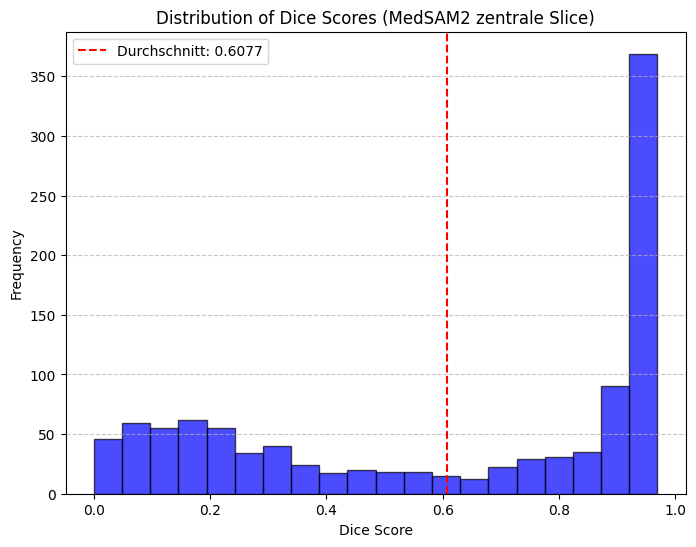

In [3]:

# Ergebnisse + Visualisierung
if dice_scores:
    # CSV speichern
    out_csv = "dice_scores_medsam2_central_slice.csv"
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (MedSAM2 zentrale Slice)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnittslinie
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    plt.savefig('dice_score_histogram_medsam2_central_slice.png')
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2 Imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierung
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# MedSAM2 Inferenzfunktion
@torch.no_grad()
def medsam2_inference(predictor, image_rgb, box_1024):
    predictor.set_image((image_rgb * 255).astype(np.uint8))  # uint8 erwartet
    masks, scores, logits = predictor.predict(
        box=box_1024,
        multimask_output=False
    )
    return masks[0].astype(np.uint8)

# Gerät
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    #ckpt_path="checkpoints/MedSAM2_2411.pt",
    ckpt_path= r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# Segmentierungsfunktion
def process_images_and_masks_with_resume(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True

            if not resume:
                progress.update(1)
                continue

            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)

            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()

            total_slices = image_data.shape[2]
            slice_start = resume_slice if mask_file == resume_file and resume_slice is not None else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as slice_progress:
                for slice_idx in range(slice_start, total_slices):
                    logging.info(f"Process Slice {slice_idx} for file {mask_file}")
                    image_slice = image_data[:, :, slice_idx]
                    mask_slice = mask_data[:, :, slice_idx]

                    if np.sum(mask_slice) == 0:
                        slice_progress.update(1)
                        continue

                    non_zero_coords = np.argwhere(mask_slice > 0)
                    y_min, x_min = non_zero_coords.min(axis=0)
                    y_max, x_max = non_zero_coords.max(axis=0)
                    box_np = np.array([[x_min, y_min, x_max, y_max]])

                    H, W = image_slice.shape
                    resized_image = transform.resize(
                        image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
                    )
                    normalized_image = (resized_image - resized_image.min()) / max(resized_image.max() - resized_image.min(), 1e-8)
                    image_rgb = np.stack([normalized_image] * 3, axis=-1)

                    box_1024 = box_np / np.array([W, H, W, H]) * 1024

                    medsam_seg = medsam2_inference(predictor, image_rgb, box_1024)

                    visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                    seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized_image, cmap="gray")
                    show_box(box_1024[0], ax[0])
                    ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Box")
                    ax[1].imshow(resized_image, cmap="gray")
                    show_mask(medsam_seg, ax[1])
                    ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                    plt.savefig(visualization_file)
                    plt.close(fig)

                    plt.imsave(seg_file, medsam_seg, cmap="gray")

                    del medsam_seg
                    gc.collect()

                    slice_progress.update(1)

            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# Ordner definieren
images_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_images"
masks_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results"
os.makedirs(output_dir, exist_ok=True)

# Starten
process_images_and_masks_with_resume(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="spleen_10.nii.gz",
    resume_slice=0
)


2025-09-08 13:20:50,562 - INFO - Verwende Gerät: cpu
2025-09-08 13:20:50,562 - INFO - Using device: cpu
2025-09-08 13:20:52,077 - INFO - Loaded checkpoint sucessfully
2025-09-08 13:20:52,363 - INFO - MedSAM2 model loaded successfully.
Slices in spleen_10.nii.gz:   0%|                                                            | 0/17 [00:00<?, ?Slice/s]2025-09-08 13:20:52,873 - INFO - Process Slice 0 for file spleen_10.nii.gz
2025-09-08 13:20:53,420 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-08 13:20:54,139 - INFO - Computing image embeddings for the provided image...
2025-09-08 13:20:56,343 - INFO - Image embeddings computed.

Slices in spleen_10.nii.gz:   6%|███                                                 | 1/17 [00:06<01:37,  6.09s/Slice]2025-09-08 13:20:58,983 - INFO - Process Slice 1 for file spleen_10.nii.gz
2025-09-08 13:20:59,155 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-08 13:20:59,243 - INFO - Computing image embeddings for the 

KeyboardInterrupt: 

In [2]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken
mask_png_folder = os.path.join("F:\Rawan_Masterarbeit","data", "Spleen", "output_masks_updated")
segmentation_results_folder = os.path.join("F:\Rawan_Masterarbeit","data", "Spleen", "MedSAM2_results_with_run_time")

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)

    if os.path.exists(segmentation_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

            # Sicherstellen, dass beide Masken binär sind (0 und 1)
            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)

            # Dice Score berechnen
            dice = dice_score(mask_png, segmentation)
            logging.info(f"{mask_filename}: Dice Score = {dice:.4f}")
            return mask_filename, dice
        except Exception as e:
            logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
        return None

# Parallelisierte Verarbeitung
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, mask_filename) for mask_filename in os.listdir(mask_png_folder) if mask_filename.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]


2025-09-08 16:20:30,431 - INFO - spleen_3_slice_08_segmentation.png: Dice Score = 0.9600
2025-09-08 16:20:30,481 - INFO - spleen_3_slice_02_segmentation.png: Dice Score = 0.9097
2025-09-08 16:20:30,460 - INFO - spleen_3_slice_03_segmentation.png: Dice Score = 0.9374
2025-09-08 16:20:30,465 - INFO - spleen_3_slice_07_segmentation.png: Dice Score = 0.9478
2025-09-08 16:20:30,465 - INFO - spleen_3_slice_05_segmentation.png: Dice Score = 0.9476
2025-09-08 16:20:30,453 - INFO - spleen_3_slice_01_segmentation.png: Dice Score = 0.7548
2025-09-08 16:20:30,490 - INFO - spleen_3_slice_06_segmentation.png: Dice Score = 0.9401
2025-09-08 16:20:30,503 - INFO - spleen_3_slice_04_segmentation.png: Dice Score = 0.9464
2025-09-08 16:20:30,658 - INFO - spleen_3_slice_14_segmentation.png: Dice Score = 0.9110
2025-09-08 16:20:30,753 - INFO - spleen_3_slice_09_segmentation.png: Dice Score = 0.9563
2025-09-08 16:20:30,778 - INFO - spleen_8_slice_03_segmentation.png: Dice Score = 0.9298
2025-09-08 16:20:30,8

2025-09-08 16:21:07,027 - INFO - 
Durchschnittlicher Dice Score: 0.9004


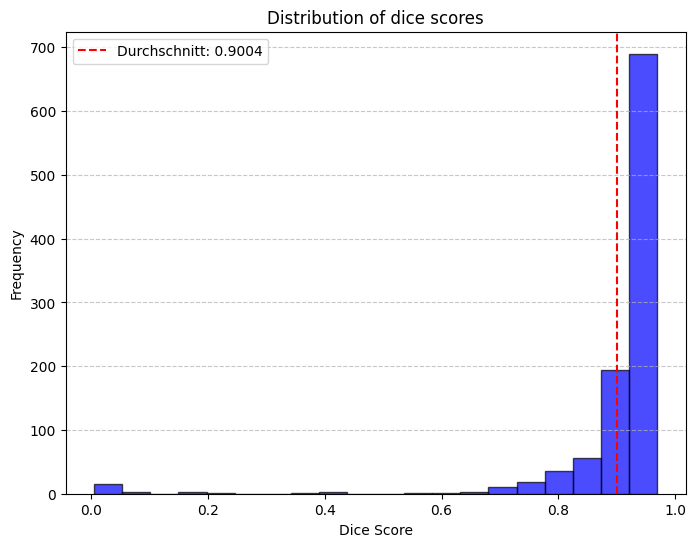

In [3]:
# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("dice_scores_medsam2.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    plt.savefig('dice_score_histogram_Medsam2_Spleen.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")


In [1]:
import os
import numpy as np
import cv2
import logging
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken
mask_png_folder = os.path.join("F:\Rawan_Masterarbeit","data", "Spleen", "output_masks_updated")
segmentation_results_folder = os.path.join("F:\Rawan_Masterarbeit","data", "Spleen", "MedSAM2_results")

# -------------------------
# Dice Score Funktion
# -------------------------
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

# -------------------------
# Hausdorff Distance & HD95
# -------------------------
def hausdorff_distance(mask1, mask2):
    # Extrahiere Koordinaten der Randpixel
    pts1 = np.argwhere(mask1 > 0)
    pts2 = np.argwhere(mask2 > 0)

    if pts1.size == 0 and pts2.size == 0:
        return 0.0, 0.0  # beide leer
    if pts1.size == 0 or pts2.size == 0:
        return np.inf, np.inf  # ein Segment fehlt komplett

    # Direkte Hausdorff-Distanz (maximaler Fehler)
    hd_forward = directed_hausdorff(pts1, pts2)[0]
    hd_backward = directed_hausdorff(pts2, pts1)[0]
    hd = max(hd_forward, hd_backward)

    # HD95 über Distance Transform
    # Distanzmaske 1 -> 2
    dt_mask2 = distance_transform_edt(1 - mask2)
    dists1 = dt_mask2[pts1[:,0], pts1[:,1]]

    # Distanzmaske 2 -> 1
    dt_mask1 = distance_transform_edt(1 - mask1)
    dists2 = dt_mask1[pts2[:,0], pts2[:,1]]

    hd95 = max(np.percentile(dists1, 95), np.percentile(dists2, 95))

    return hd, hd95

# -------------------------
# Verarbeitung einer Datei
# -------------------------
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)

    if os.path.exists(segmentation_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)

            # Dice & Hausdorff berechnen
            dice = dice_score(mask_png, segmentation)
            hd, hd95 = hausdorff_distance(mask_png, segmentation)

            logging.info(f"{mask_filename}: Dice={dice:.4f}, HD={hd:.4f}, HD95={hd95:.4f}")
            return mask_filename, dice, hd, hd95

        except Exception as e:
            logging.error(f"Fehler bei {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei fehlt für {mask_filename}")
        return None

# -------------------------
# Parallelisierte Verarbeitung
# -------------------------
results = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, fn)
               for fn in os.listdir(mask_png_folder) if fn.endswith(".png")]
    results = [f.result() for f in futures if f.result() is not None]

# Ergebnisse als Liste [(filename, dice, hd, hd95), ...]


2025-09-08 11:26:58,817 - INFO - spleen_3_slice_01_segmentation.png: Dice=0.7548, HD=7.00, HD95=5.00
2025-09-08 11:26:58,997 - INFO - spleen_3_slice_04_segmentation.png: Dice=0.9464, HD=6.08, HD95=2.00
2025-09-08 11:26:59,077 - INFO - spleen_3_slice_03_segmentation.png: Dice=0.9374, HD=7.07, HD95=2.83
2025-09-08 11:26:59,083 - INFO - spleen_3_slice_05_segmentation.png: Dice=0.9476, HD=8.49, HD95=2.00
2025-09-08 11:26:59,099 - INFO - spleen_3_slice_08_segmentation.png: Dice=0.9600, HD=8.54, HD95=0.00
2025-09-08 11:26:59,117 - INFO - spleen_3_slice_06_segmentation.png: Dice=0.9401, HD=9.90, HD95=3.00
2025-09-08 11:27:00,559 - INFO - spleen_3_slice_07_segmentation.png: Dice=0.9478, HD=11.40, HD95=1.00
2025-09-08 11:27:00,974 - INFO - spleen_3_slice_02_segmentation.png: Dice=0.9097, HD=6.00, HD95=3.61
2025-09-08 11:27:04,466 - INFO - spleen_3_slice_10_segmentation.png: Dice=0.9522, HD=15.00, HD95=2.24
2025-09-08 11:27:04,587 - INFO - spleen_3_slice_09_segmentation.png: Dice=0.9563, HD=9.43

In [3]:
# === Ergebnisse speichern & visualisieren (Dice, HD, HD95) ===
import csv
import numpy as np
import matplotlib.pyplot as plt

if results:
    # In CSV speichern
    csv_path = "metrics_medsam2_spleen.csv"
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["Maskenname", "Dice", "HD", "HD95"])
        for row in results:
            w.writerow(row)
    logging.info(f"CSV gespeichert: {csv_path}")

    # Arrays bauen
    names   = [r[0] for r in results]
    dice    = np.array([r[1] for r in results], dtype=float)
    hd_all  = np.array([r[2] for r in results], dtype=float)
    hd95_all= np.array([r[3] for r in results], dtype=float)

    # ggf. ∞-Werte (leere/fehlende Segmente) für Statistiken/Plots filtern
    finite_mask_hd   = np.isfinite(hd_all)
    finite_mask_hd95 = np.isfinite(hd95_all)

    # Basis-Statistiken
    def stats_str(x):
        if x.size == 0: return "n/a"
        return f"mean={np.mean(x):.4f}, median={np.median(x):.4f}, std={np.std(x):.4f}"

    logging.info(f"Dice      -> {stats_str(dice)}")
    logging.info(f"HD        -> {stats_str(hd_all[finite_mask_hd])}")
    logging.info(f"HD95      -> {stats_str(hd95_all[finite_mask_hd95])}")

    # --- Histogramm: Dice ---
    plt.figure(figsize=(8,6))
    plt.hist(dice, bins=25, edgecolor='black')
    avg_dice = np.mean(dice)
    plt.axvline(avg_dice, linestyle='--', linewidth=2, label=f"Mean = {avg_dice:.4f}")
    plt.title("Distribution of Dice Scores (Spleen, MedSAM2)")
    plt.xlabel("Dice")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig("hist_dice_medsam2_spleen.png", dpi=150)
    plt.close()

    # --- Histogramm: HD95 (robuster Randfehler) ---
    if np.any(finite_mask_hd95):
        plt.figure(figsize=(8,6))
        plt.hist(hd95_all[finite_mask_hd95], bins=25, edgecolor='black')
        avg_hd95 = np.mean(hd95_all[finite_mask_hd95])
        plt.axvline(avg_hd95, linestyle='--', linewidth=2, label=f"Mean = {avg_hd95:.3f}")
        plt.title("Distribution of HD95 (Spleen, MedSAM2)")
        plt.xlabel("HD95 (Pixel oder mm)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.savefig("hist_hd95_medsam2_spleen.png", dpi=150)
        plt.close()

    # --- Histogramm: HD (Worst Case) ---
    if np.any(finite_mask_hd):
        plt.figure(figsize=(8,6))
        plt.hist(hd_all[finite_mask_hd], bins=25, edgecolor='black')
        avg_hd = np.mean(hd_all[finite_mask_hd])
        plt.axvline(avg_hd, linestyle='--', linewidth=2, label=f"Mean = {avg_hd:.3f}")
        plt.title("Distribution of HD (Spleen, MedSAM2)")
        plt.xlabel("HD (Pixel oder mm)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.savefig("hist_hd_medsam2_spleen.png", dpi=150)
        plt.close()

    # --- Scatter: Dice vs. HD95 (je kleiner HD95, desto besser) ---
    if np.any(finite_mask_hd95):
        plt.figure(figsize=(7,6))
        plt.scatter(dice[finite_mask_hd95], hd95_all[finite_mask_hd95], alpha=0.7)
        plt.title("Dice vs. HD95 (Spleen, MedSAM2)")
        plt.xlabel("Dice")
        plt.ylabel("HD95 (Pixel oder mm)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.savefig("scatter_dice_vs_hd95_spleen.png", dpi=150)
        plt.close()

    # --- Optional: Boxplots (robuste Übersicht) ---
    plt.figure(figsize=(7,6))
    data = [dice]
    labels = ["Dice"]
    if np.any(finite_mask_hd95):
        data.append(hd95_all[finite_mask_hd95])
        labels.append("HD95")
    if np.any(finite_mask_hd):
        data.append(hd_all[finite_mask_hd])
        labels.append("HD")
    plt.boxplot(data, labels=labels, showmeans=True)
    plt.title("Boxplots: Dice / HD95 / HD")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.savefig("boxplots_metrics_spleen.png", dpi=150)
    plt.close()

else:
    logging.info("Keine Ergebnisse vorhanden – erst 'results' befüllen.")


2025-09-08 11:35:20,949 - INFO - CSV gespeichert: metrics_medsam2_spleen.csv
2025-09-08 11:35:20,952 - INFO - Dice      -> mean=0.9009, median=0.9359, std=0.1326
2025-09-08 11:35:20,954 - INFO - HD        -> mean=15.1051, median=10.1980, std=18.5024
2025-09-08 11:35:20,956 - INFO - HD95      -> mean=5.4437, median=3.0000, std=14.3168
C:\Users\rawan\AppData\Local\Temp\ipykernel_4116\1042399828.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


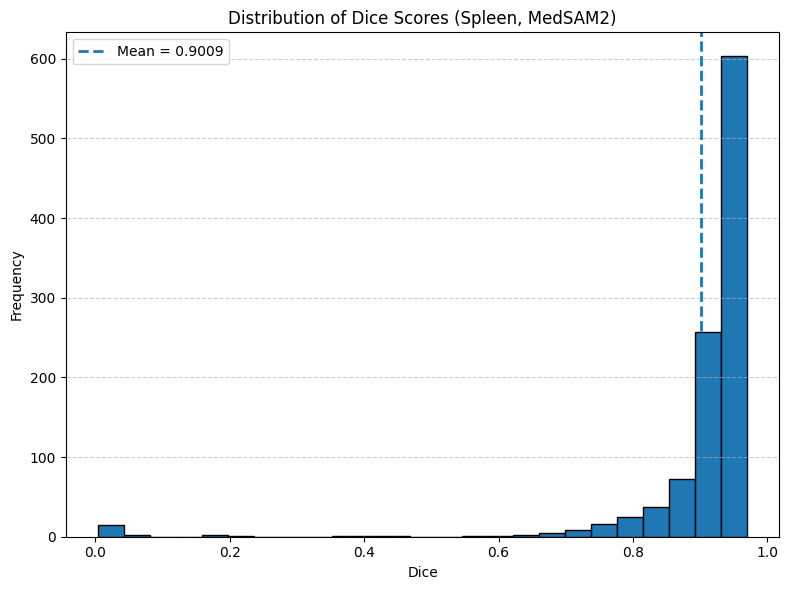

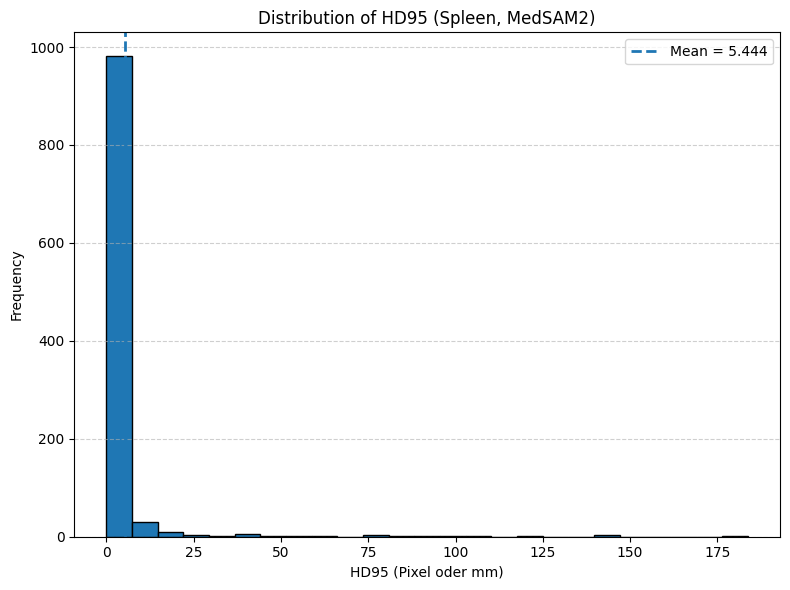

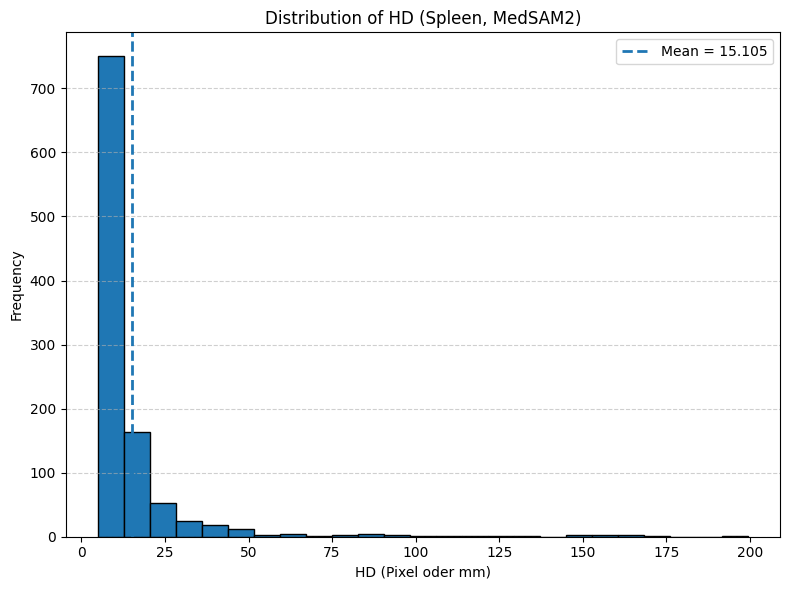

In [5]:
# --- Histogramm: Dice ---
plt.figure(figsize=(8,6))
plt.hist(dice, bins=25, edgecolor='black')
avg_dice = np.mean(dice)
plt.axvline(avg_dice, linestyle='--', linewidth=2, label=f"Mean = {avg_dice:.4f}")
plt.title("Distribution of Dice Scores (Spleen, MedSAM2)")
plt.xlabel("Dice"); plt.ylabel("Frequency"); plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("hist_dice_medsam2_spleen.png", dpi=150)
plt.show()
plt.close()

# --- Histogramm: HD95 ---
plt.figure(figsize=(8,6))
plt.hist(hd95_all[np.isfinite(hd95_all)], bins=25, edgecolor='black')
avg_hd95 = np.mean(hd95_all[np.isfinite(hd95_all)])
plt.axvline(avg_hd95, linestyle='--', linewidth=2, label=f"Mean = {avg_hd95:.3f}")
plt.title("Distribution of HD95 (Spleen, MedSAM2)")
plt.xlabel("HD95 (Pixel oder mm)"); plt.ylabel("Frequency"); plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("hist_hd95_medsam2_spleen.png", dpi=150)
plt.show()
plt.close()

# --- Histogramm: HD ---
plt.figure(figsize=(8,6))
plt.hist(hd_all[np.isfinite(hd_all)], bins=25, edgecolor='black')
avg_hd = np.mean(hd_all[np.isfinite(hd_all)])
plt.axvline(avg_hd, linestyle='--', linewidth=2, label=f"Mean = {avg_hd:.3f}")
plt.title("Distribution of HD (Spleen, MedSAM2)")
plt.xlabel("HD (Pixel oder mm)"); plt.ylabel("Frequency"); plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("hist_hd_medsam2_spleen.png", dpi=150)
plt.show()
plt.close()





2025-09-08 11:39:48,607 - INFO - CSV gespeichert: F:\Rawan_Masterarbeit\MedSAM2\sam2\metrics_medsam2_spleen.csv
2025-09-08 11:39:48,608 - INFO - Dice -> mean=0.9009, median=0.9359, std=0.1326
2025-09-08 11:39:48,610 - INFO - HD   -> mean=15.1051, median=10.1980, std=18.5024
2025-09-08 11:39:48,612 - INFO - HD95 -> mean=5.4437, median=3.0000, std=14.3168


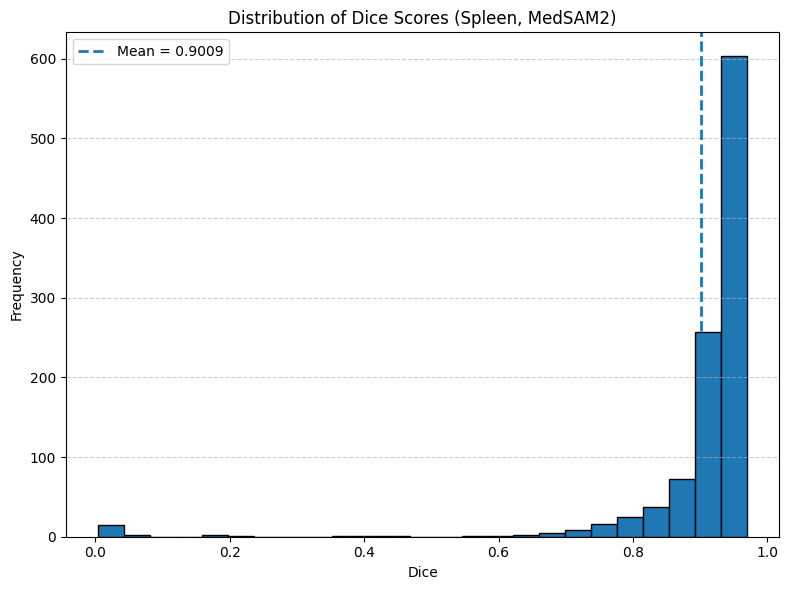

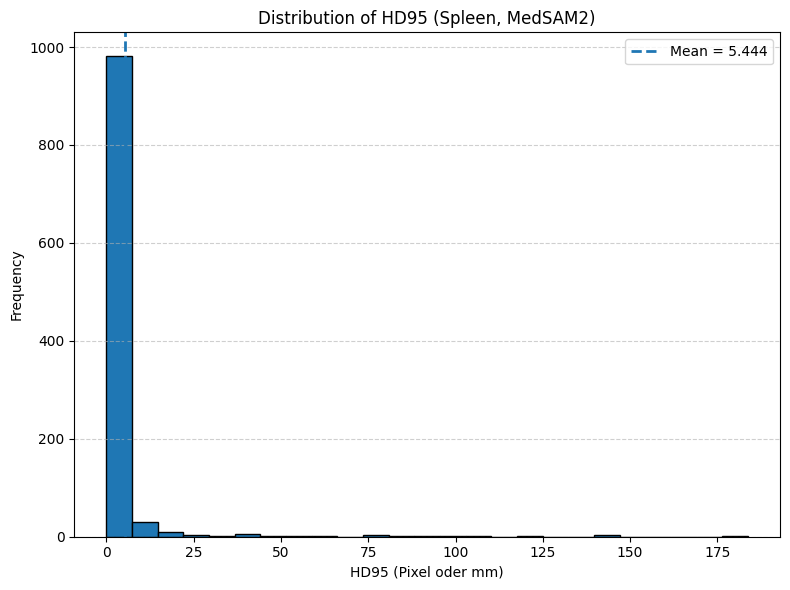

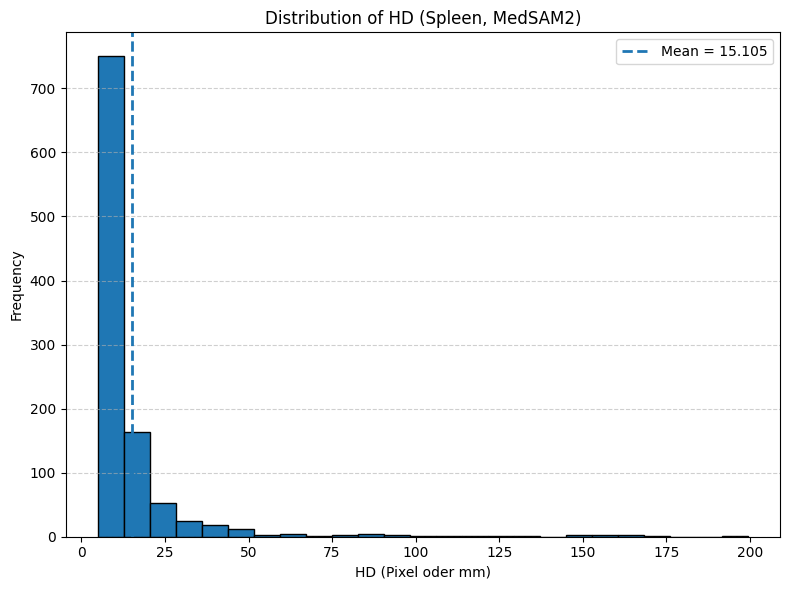

In [6]:
# === Ergebnisse speichern & visualisieren (Dice, HD, HD95) ===
import csv
import numpy as np
import matplotlib.pyplot as plt
import logging
import os

if results:
    # In CSV speichern
    csv_path = "metrics_medsam2_spleen.csv"
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["Maskenname", "Dice", "HD", "HD95"])
        for row in results:
            w.writerow(row)
    logging.info(f"CSV gespeichert: {os.path.abspath(csv_path)}")

    # Arrays bauen
    names   = [r[0] for r in results]
    dice    = np.array([r[1] for r in results], dtype=float)
    hd_all  = np.array([r[2] for r in results], dtype=float)
    hd95_all= np.array([r[3] for r in results], dtype=float)

    # ∞-Werte filtern
    finite_mask_hd   = np.isfinite(hd_all)
    finite_mask_hd95 = np.isfinite(hd95_all)

    # Basis-Statistiken
    def stats_str(x):
        if x.size == 0: return "n/a"
        return f"mean={np.mean(x):.4f}, median={np.median(x):.4f}, std={np.std(x):.4f}"

    logging.info(f"Dice -> {stats_str(dice)}")
    logging.info(f"HD   -> {stats_str(hd_all[finite_mask_hd])}")
    logging.info(f"HD95 -> {stats_str(hd95_all[finite_mask_hd95])}")

    # --- Histogramm: Dice ---
    plt.figure(figsize=(8,6))
    plt.hist(dice, bins=25, edgecolor='black')
    avg_dice = np.mean(dice)
    plt.axvline(avg_dice, linestyle='--', linewidth=2, label=f"Mean = {avg_dice:.4f}")
    plt.title("Distribution of Dice Scores (Spleen, MedSAM2)")
    plt.xlabel("Dice"); plt.ylabel("Frequency"); plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("hist_dice_medsam2_spleen.png", dpi=150)
    plt.show()
    plt.close()

    # --- Histogramm: HD95 ---
    if np.any(finite_mask_hd95):
        plt.figure(figsize=(8,6))
        plt.hist(hd95_all[finite_mask_hd95], bins=25, edgecolor='black')
        avg_hd95 = np.mean(hd95_all[finite_mask_hd95])
        plt.axvline(avg_hd95, linestyle='--', linewidth=2, label=f"Mean = {avg_hd95:.3f}")
        plt.title("Distribution of HD95 (Spleen, MedSAM2)")
        plt.xlabel("HD95 (Pixel oder mm)"); plt.ylabel("Frequency"); plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig("hist_hd95_medsam2_spleen.png", dpi=150)
        plt.show()
        plt.close()

    # --- Histogramm: HD ---
    if np.any(finite_mask_hd):
        plt.figure(figsize=(8,6))
        plt.hist(hd_all[finite_mask_hd], bins=25, edgecolor='black')
        avg_hd = np.mean(hd_all[finite_mask_hd])
        plt.axvline(avg_hd, linestyle='--', linewidth=2, label=f"Mean = {avg_hd:.3f}")
        plt.title("Distribution of HD (Spleen, MedSAM2)")
        plt.xlabel("HD (Pixel oder mm)"); plt.ylabel("Frequency"); plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig("hist_hd_medsam2_spleen.png", dpi=150)
        plt.show()
        plt.close()


 
else:
    logging.info("Keine Ergebnisse vorhanden – erst 'results' befüllen.")


# MedSAM2 + Runtime

In [1]:
# -*- coding: utf-8 -*-
import os
import json
import time
import csv
import gc
import logging
from typing import Optional, Tuple

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
import torch
from tqdm import tqdm

# =============== MedSAM2 Imports ===============
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ========================= Logging =========================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# =================== Visualisierungsfunktionen ===================
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# =================== Gerät & Modell ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam2_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    # Passe den Pfad an deine Umgebung an:
    ckpt_path=r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam2_model)
logging.info("MedSAM2 Modell erfolgreich geladen.")

# =================== Helpers ===================
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    """
    Summiert die Spalte 'seconds' aus timing_per_slice.csv über alle Runs.
    Robust ohne pandas.
    """
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

# =================== Zeitmessung (Wall-Clock + CSV-Gesamt) ===================
def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Konnte Runtime-State nicht lesen: {e}")
    return {
        "sessions": [],             # [{start, end, elapsed_sec}]
        "total_elapsed_sec": 0.0,   # akkumulierte Wall-Clock-Zeit über Sessions (informativ)
    }

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Führt func aus, misst Laufzeit des aktuellen Runs und akkumuliert in state_path.
    Zusätzlich wird am Ende die *echte* Gesamtlaufzeit über alle Neustarts
    aus timing_per_slice.csv (seed_timing_csv) berechnet und geloggt.
    """
    state = _load_runtime_state(state_path)

    start = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")

    try:
        return func(*args, **kwargs)  # kwargs enthält später timing_csv für die Pipeline
    finally:
        elapsed = time.perf_counter() - start
        end_wall = time.time()

        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        # 1) Wall-Clock (informativ)
        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)

        # 2) CSV-basierte Gesamtsumme (entscheidend) – aus seed_timing_csv
        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)

        with open("runtime_log_medsam2.txt", "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# =================== Resume-Checkpoint ===================
def save_resume_state(checkpoint_path: str, filename: str, slice_idx: int):
    state = {"resume_file": filename, "resume_slice": slice_idx}
    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(state, f)

def load_resume_state(checkpoint_path: str) -> Tuple[Optional[str], Optional[int]]:
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, "r", encoding="utf-8") as f:
                state = json.load(f)
            return state.get("resume_file"), state.get("resume_slice")
        except Exception as e:
            logging.warning(f"Checkpoint konnte nicht gelesen werden: {e}")
    return None, None

# =================== MedSAM2 Inferenz ===================
@torch.no_grad()
def medsam2_inference(predictor: SAM2ImagePredictor, image_rgb: np.ndarray, box_1024: np.ndarray) -> np.ndarray:
    """
    image_rgb: (H,W,3) float in [0,1]
    box_1024:  (1,4) in 1024-Koordinaten [x0,y0,x1,y1]
    """
    # SAM2 erwartet uint8 Bild
    predictor.set_image((image_rgb * 255).astype(np.uint8))
    masks, scores, logits = predictor.predict(
        box=box_1024.squeeze().tolist(),  # Liste [x0,y0,x1,y1]
        multimask_output=False
    )
    return masks[0].astype(np.uint8)

# =================== Pipeline (Spleen) ===================
def process_images_and_masks_with_resume(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    checkpoint_path: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    resume_slice: Optional[int] = None,
    use_auto_resume: bool = True,
):
    """
    - Segmentiert alle Spleen-Volumes sliceweise mit MedSAM2.
    - Schreibt VOR JEDEM Slice einen Resume-Checkpoint.
    - Hängt pro Slice die Laufzeit an timing_csv an (persistiert über Neustarts).
    """
    os.makedirs(output_dir, exist_ok=True)

    # Auto-Resume
    if use_auto_resume and (resume_file is None and resume_slice is None):
        cf, cs = load_resume_state(checkpoint_path)
        if cf is not None:
            logging.info(f"Automatischer Resume → Datei={cf}, Slice={cs}")
            resume_file, resume_slice = cf, cs

    # timing CSV initialisieren (Header nur einmal)
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    # Dateiliste (Bild-Dateien treiben die Iteration; gleiche Namen für Masken erwartet)
    nii_files = sorted([f for f in os.listdir(images_dir) if f.endswith((".nii", ".nii.gz"))])
    resume_armed = resume_file is None  # erst ab resume_file loslegen

    with tqdm(total=len(nii_files), desc="Dateien", unit="Datei") as prog_files:
        for image_file in nii_files:
            image_path = os.path.join(images_dir, image_file)
            mask_path  = os.path.join(masks_dir,  image_file)  # gleicher Dateiname erwartet

            if not os.path.exists(mask_path):
                logging.warning(f"Fehlende Maske: {image_file}")
                prog_files.update(1)
                continue

            if not resume_armed:
                if image_file == resume_file:
                    resume_armed = True
                else:
                    prog_files.update(1)
                    continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            img = nifti_image.get_fdata()
            msk = nifti_mask.get_fdata()

            total_slices = img.shape[2]
            slice_start = resume_slice if (image_file == resume_file and resume_slice is not None) else 0

            with tqdm(total=total_slices, desc=f"Slices in {image_file}", unit="Slice") as prog_slices:
                for slice_idx in range(slice_start, total_slices):
                    t0 = time.perf_counter()
                    try:
                        # Checkpoint vor der Bearbeitung schreiben
                        save_resume_state(checkpoint_path, image_file, slice_idx)

                        image_slice = img[:, :, slice_idx]
                        mask_slice  = msk[:, :, slice_idx]

                        if np.sum(mask_slice) == 0:
                            # leere GT → Überspringen (aber Zeit/Progress zählen)
                            elapsed_slice = time.perf_counter() - t0
                            with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                                csv.writer(fcsv).writerow([image_file, slice_idx, f"{elapsed_slice:.4f}"])
                            prog_slices.update(1)
                            continue

                        # Vorverarbeitung
                        H, W = image_slice.shape
                        resized_image = transform.resize(
                            image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
                        )
                        # robust normalisieren
                        ptp = resized_image.max() - resized_image.min()
                        normalized_image = (resized_image - resized_image.min()) / max(ptp, 1e-8)
                        image_rgb = np.stack([normalized_image] * 3, axis=-1)

                        # Bounding Box aus GT-Maske (in Original-Auflösung berechnet, dann auf 1024 skaliert)
                        yx = np.argwhere(mask_slice > 0)
                        y_min, x_min = yx.min(axis=0)
                        y_max, x_max = yx.max(axis=0)
                        box_np = np.array([[x_min, y_min, x_max, y_max]], dtype=np.float32)
                        box_1024 = box_np / np.array([W, H, W, H], dtype=np.float32) * 1024.0

                        # MedSAM2 Inferenz
                        medsam2_seg = medsam2_inference(predictor, image_rgb, box_1024)

                        # Speichern (Visualisierung + Maske)
                        vis_file = os.path.join(output_dir, f"{image_file}_slice_{slice_idx}_visualization.png")
                        seg_file = os.path.join(output_dir, f"{image_file}_slice_{slice_idx}_segmentation.png")

                        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                        ax[0].imshow(resized_image, cmap="gray")
                        show_box(box_1024[0], ax[0])
                        ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Box")
                        ax[1].imshow(resized_image, cmap="gray")
                        show_mask(medsam2_seg, ax[1])
                        ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                        plt.savefig(vis_file)
                        plt.close(fig)

                        plt.imsave(seg_file, medsam2_seg, cmap="gray")

                        # Cleanup
                        del medsam2_seg
                        gc.collect()

                    except Exception as e:
                        logging.error(f"Fehler bei {image_file} Slice {slice_idx}: {e}")
                    finally:
                        # Slice-Zeit anhängen (persistiert über alle Runs)
                        elapsed_slice = time.perf_counter() - t0
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([image_file, slice_idx, f"{elapsed_slice:.4f}"])
                        prog_slices.update(1)

            prog_files.update(1)

    # Fertig → Checkpoint löschen
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        logging.info("Checkpoint entfernt (Pipeline abgeschlossen).")

# =================== AUSFÜHRUNG (Spleen) ===================
if __name__ == "__main__":
    # Ordner definieren (passe an deine Pfade an)
    images_dir = r"F:\Rawan_Masterarbeit\data\Spleen\output_images"
    masks_dir  = r"F:\Rawan_Masterarbeit\data\Spleen\output_masks"
    output_dir = r"F:\Rawan_Masterarbeit\data\Spleen\MedSAM2_results_with_run_time"
    os.makedirs(output_dir, exist_ok=True)

    checkpoint_path = os.path.join(output_dir, "resume_checkpoint.json")
    timing_csv      = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state   = os.path.join(output_dir, "runtime_state.json")

    # Manuelles Resume (optional). Wenn None/None → Auto-Resume via JSON.
    manual_resume_file  = None   # z.B. "spleen_44.nii.gz"
    manual_resume_slice = None

    # Lauf starten (Wall-Clock akkumuliert + CSV-basierte Gesamtzeit)
    time_run_accumulate(
        process_images_and_masks_with_resume,
        runtime_state,              # state_path
        seed_timing_csv=timing_csv, # <-- NUR für den Wrapper (Summe am Ende)
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        checkpoint_path=checkpoint_path,
        timing_csv=timing_csv,      # <-- für die Pipeline-Funktion (Pflichtargument)
        resume_file=manual_resume_file,
        resume_slice=manual_resume_slice,
        use_auto_resume=True,
    )

    # Optional: CSV-Gesamtzeit explizit loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit aus CSV (alle Neustarts): {_fmt(total_csv_sec)}")


2025-09-08 15:49:49,237 - INFO - Verwende Gerät: cpu
2025-09-08 15:49:49,238 - INFO - Using device: cpu
2025-09-08 15:49:54,842 - INFO - Loaded checkpoint sucessfully
2025-09-08 15:49:55,610 - INFO - MedSAM2 Modell erfolgreich geladen.
2025-09-08 15:49:55,641 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
2025-09-08 15:49:55,644 - INFO - Automatischer Resume → Datei=spleen_61.nii.gz, Slice=13
Slices in spleen_61.nii.gz:   0%|                                                            | 0/14 [00:00<?, ?Slice/s]2025-09-08 15:49:58,376 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-08 15:49:58,699 - INFO - Computing image embeddings for the provided image...
2025-09-08 15:50:00,357 - INFO - Image embeddings computed.

Slices in spleen_62.nii.gz:   0%|                                                            | 0/21 [00:00<?, ?Slice/s]2025-09-08 15:50:03,034 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-08 15:50:03,127 - INFO - Computing image

In [ ]:
import sam2, inspect, os, sys
print("sam2 wird geladen von:", inspect.getfile(sam2))
print("Python sucht in:", sys.path[:3])
print("Gibt es 'modeling'? ->", os.path.exists(os.path.join(os.path.dirname(inspect.getfile(sam2)), "modeling")))


In [2]:
import os, glob
print("cwd:", os.getcwd())
print("ckpt exists:", os.path.exists(r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt"))
print("configs:", glob.glob(r"F:\Rawan_Masterarbeit\MedSAM2_old\sam2\configs\*.yaml")[:5])


cwd: F:\Rawan_Masterarbeit\MedSAM2_old\sam2
ckpt exists: True
configs: ['F:\\Rawan_Masterarbeit\\MedSAM2_old\\sam2\\configs\\efficientmedsam_s_512_FLARE_RECIST.yaml', 'F:\\Rawan_Masterarbeit\\MedSAM2_old\\sam2\\configs\\efficientmedsam_ti_512_FLARE_RECIST.yaml', 'F:\\Rawan_Masterarbeit\\MedSAM2_old\\sam2\\configs\\efficienttam_ti_512.yaml', 'F:\\Rawan_Masterarbeit\\MedSAM2_old\\sam2\\configs\\sam2.1_hiera_t512.yaml', 'F:\\Rawan_Masterarbeit\\MedSAM2_old\\sam2\\configs\\sam2.1_hiera_tiny512_FLARE_RECIST.yaml']


In [4]:
import os, sys

REPO_ROOT = r"F:\Rawan_Masterarbeit\MedSAM2_old"
sys.path.insert(0, REPO_ROOT)  # sicherstellen, dass NICHT '...MedSAM2_old...' benutzt wird

config_file = os.path.join(REPO_ROOT, "sam2", "configs", "sam2.1_hiera_t512.yaml")  # nimm genau eine existierende YAML
ckpt_path   = os.path.join(REPO_ROOT, "checkpoints", "MedSAM2_2411.pt")             # lege die .pt dorthin

assert os.path.exists(config_file), f"Config fehlt: {config_file}"
assert os.path.exists(ckpt_path),   f"Checkpoint fehlt: {ckpt_path}"

medsam2_model = build_sam2(
    config_file=config_file,
    ckpt_path=ckpt_path,
    device=device
)


2025-09-08 12:40:32,521 - INFO - Using device: cpu
2025-09-08 12:40:37,889 - INFO - Loaded checkpoint sucessfully


In [ ]:
%cd F:\Rawan_Masterarbeit\MedSAM2_old
!pip install -e ".[dev]"


F:\Rawan_Masterarbeit\MedSAM2_old


In [ ]:
!pip install efficient-track-anything

In [3]:
import sys; print(sys.executable)


F:\Rawan_Masterarbeit\venv_medsam2\Scripts\python.exe


In [4]:
%cd F:\Rawan_Masterarbeit\MedSAM2_old
%pip install -e ".[dev]"


F:\Rawan_Masterarbeit\MedSAM2_old
Obtaining file:///F:/Rawan_Masterarbeit/MedSAM2_old
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached black-24.2.0-cp311-cp311-win_amd64.whl.metadata (74 kB)
  Using cached usort-1.0.2-py3-none-any.whl.metadata (3.3 kB)
  Using cached ufmt-2.0.0b2-py3-none-any.whl.metadata (3.9 kB)
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached pycocotools-2.0.10-cp311-cp311-win_amd64.whl.metadata (1.3 kB)
  Using cached ten


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: F:\Rawan_Masterarbeit\venv_medsam2\Scripts\python.exe -m pip install --upgrade pip


Download all models (Dowenload all checkpoints) to a specific folder (MedSAM2/checkpoints)


In [2]:
from huggingface_hub import hf_hub_download
import os

# Create checkpoints directory if it doesn't exist
os.makedirs("../checkpoints", exist_ok=True)

# List of model filenames
model_files = [
    "MedSAM2_2411.pt",
    "MedSAM2_US_Heart.pt",
    "MedSAM2_MRI_LiverLesion.pt",
    "MedSAM2_CTLesion.pt",
    "MedSAM2_latest.pt"
]

# Download all models
for model_file in model_files:
    local_path = os.path.join("checkpoints", model_file)
    hf_hub_download(
        repo_id="wanglab/MedSAM2",
        filename=model_file,
        local_dir="checkpoints",
        local_dir_use_symlinks=False
    )
    print(f"Downloaded {model_file} to {local_path}")


Downloaded MedSAM2_2411.pt to checkpoints\MedSAM2_2411.pt
Downloaded MedSAM2_US_Heart.pt to checkpoints\MedSAM2_US_Heart.pt
Downloaded MedSAM2_MRI_LiverLesion.pt to checkpoints\MedSAM2_MRI_LiverLesion.pt
Downloaded MedSAM2_CTLesion.pt to checkpoints\MedSAM2_CTLesion.pt
Downloaded MedSAM2_latest.pt to checkpoints\MedSAM2_latest.pt


## Step 1: Installation and Setup

In [2]:
# Installiere das MedSAM2-Repository
!git clone https://github.com/bowang-lab/MedSAM2.git
%cd MedSAM2
%pip install -e .

# Modell-Checkpoint herunterladen
#!mkdir -p checkpoints
#!curl -L -o checkpoints/MedSAM2_2411.pt https://huggingface.co/wanglab/MedSAM2/resolve/main/MedSAM2_2411.pt

^C
F:\Rawan_Masterarbeit\MedSAM2_old\sam2\MedSAM2
Obtaining file:///F:/Rawan_Masterarbeit/MedSAM2_old/sam2/MedSAM2
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: F:\Rawan_Masterarbeit\venv_medsam2\Scripts\python.exe -m pip install --upgrade pip
ERROR: file:///F:/Rawan_Masterarbeit/MedSAM2_old/sam2/MedSAM2 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Cloning into 'MedSAM2'...
Updating files:  11% (13/113)
Updating files:  12% (14/113)
Updating files:  13% (15/113)
Updating files:  14% (16/113)
Updating files:  15% (17/113)
Updating files:  16% (19/113)
Updating files:  17% (20/113)
Updating files:  18% (21/113)
Updating files:  19% (22/113)
Updating files:  20% (23/113)
Updating files:  21% (24/113)
Updating files:  22% (25/113)
Updating files:  23% (26/113)
Updating files:  24% (28/113)
Updating files:  25% (29/113)
Updating files:  26% (30/113)
Updating files:  27% (31/113)
Updating files:  28% (32/113)
Updating files:  29% (33/113)
Updating files:  30% (34/113)
Updating files:  31% (36/113)
Updating files:  32% (37/11

In [5]:
!curl -L https://github.com/bowang-lab/MedSAM2/releases/download/v1.0/MedSAM2_latest.pt -o MedSAM2/checkpoints/MedSAM2_latest.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file MedSAM2/checkpoints/MedSAM2_latest.pt: No 

  0     9    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) client returned ERROR on write of 9 bytes
